# Ramsey King
# DSC 550 - Data Mining
# November 7, 2021
# Term Project Milestone 4

### My term project will consist of being able to guess the main topic of sermons given by members of The Church of Jesus Christ of Latter Day Saints as defined by the designated topic assigned to it at speeches.byu.edu.  The ability to search for sermons by topic on this website is available.  While this specific case is not a business use case of data mining, there are many business use cases for being able to identify text by topic or keyword (i.e. www.google.com).  
### For purposes of this assignment, being able to quickly find topic related sermons is beneficial to members of the Church of Jesus Christ.  On occasion, members of the church are asked to give a sermon of their own on various topics, and having the ability to go to a resource and search the assigned topic by keyword helps to generate discussion points and give guidance as to what is appropriate to discuss.  For this project, we will limit the topics as defined by speeches.byu.edu. to give us an initial dataset of 800 rows before processing.  The topics and the count of the number of sermons given (as of October 4th, 2021) are: Life (108), Jesus Christ (106), Faith (100), Learning (97), Service (73), Discipleship (67), Righteousness (67), Divine Potential (66), Love (66), Adversity (57), Trials (56), Revelation (55), and Missionary Work (53).  This should provide enough data to work with but if there is a need, additional topics will be included to help with the corpus.  

In [58]:
# Retrieve talks from topics page using BeautifulSoup

from bs4 import BeautifulSoup as bs
import requests
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

Now that we have BeautifulSoup imported, we will gather the links on the speeches.byu.edu website based on the topics listed above (Faith, Learning, Service, etc.).  

In [59]:
# Get list of urls for each of the topics

url = "https://speeches.byu.edu/topics/"

url_list = [
    'life/', 'jesus-christ/', 'faith/', 'learning/', 'service/', 'discipleship/', 'righteousness/', 
    'divine-potential/', 'love/', 'adversity/', 'trials/', 'revelation/', 'missionary-work/'
]

links = []
new_links = []
# some of the links are repeated with '?M=V' and '?M=A' and those will be removed so we can have a unique set of links to pull talk information from.
for u in url_list:

    response = requests.get(url+u)
    html = response.content
    video = '?M=V'
    soup = bs(html, "lxml")
    for link in soup.findAll("a", attrs={'href': re.compile("^https://speeches.byu.edu/talks/[\D+]")}):
        links.append(link.get('href').replace(video, ''))

    audio = '?M=A'
    for link in links:
        new_link = link.replace(audio, '')
        new_links.append(new_link)
    new_links = list(set(new_links))



Now that the links have been gathered into a list, we will use this list to retrieve the individual sermon/talk/speech text from the respective link.  On a specific speech page, the following information will be gathered:
 - Speaker name
 - Talk title
 - Assigned topic
 - Date when the talk was given
 - The speaker's title (if they have a certain position within The Church of Jesus Christ of Latter Day Saints, Brigham Young University, etc.  If there is no position or title listed for the speaker, we will return 'Title Not Found')
 - The talk text

 This information will be combined into a dataframe for analysis.  This information will also be combined into a csv file in case work needs to be completed offline.

In [60]:
'''Retrieves talk text from each of the urls using beautiful soup.  Information such as the talk/sermon text, title, topic, date, and speaker will be retreived
and put into a dataframe.  A csv file will also be saved due to the time it takes to run or in case we need to work offline.'''
talk_text = []
title_text = []
topics = []
dates = []
speakers = []
speaker_position = []

for link in new_links:
    url = link
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    temp_list = []

    link_splitter = link.split('/')
    speakers.append(link_splitter[4].replace('-', ' '))

    result = soup.find('p', class_='single-speech__speaker-subtext single-speech__speaker-position')
    speaker_position.append(result.text if result else 'Title Not Found')

    for div in soup.find_all('div', class_='single-speech__content'):
        talk_text.append(div.get_text(strip=True))
    for h1 in soup.find_all('h1', class_='single-speech__title'):
        title_text.append(h1.get_text(strip=True))        
    for p in soup.find_all('p', class_='single-speech__speaker-subtext single-speech__date'):
        dates.append(p.get_text(strip=True))
    for p in soup.find_all('p', class_='single-speech__related-tag'):
        temp_list.append(p.get_text(strip=True))
        temp_str = ','.join(temp_list)
    topics.append(temp_str)


dict = {'titles': title_text , 'speaker': speakers, 'speaker_position': speaker_position , 'date': dates, 'talks': talk_text, 'topics': topics, }
df = pd.DataFrame(dict)
# df.to_csv('talks.csv')

Now that the talk information has been combined into a dataframe, we can begin pre-processing and gathering initial statistical information.  To begin, we will get the word count of each talk and place it in one of our columns.

In [61]:
# get word count of each talk
df['word_count'] = df['talks'].apply(lambda x: len(re.findall(r'\w+', x)))

Some talks have multiple topic associated with them on their webpage where the talk text was retrieved.  For purposes of this exercise (and project), we will take the first topic that is listed on the page and that will be our defining topic that will be used for analysis and modeling.  We will also create time columns (Month, Year, and month as an integer) to see if insights can be gained from them. 

In [62]:
# reduce the topic to the ones selected from our original selection ('life', 'jesus-christ', 'faith', 'learning', 'service')
from datetime import datetime
# the single_topic function takes the list of topics in the 'topics' column and will return the first topic it finds in the 'topic_selection_list'
def single_topic(dataframe_topics):
    column = [word for word in dataframe_topics.split(',')]
    the_string =  ', '.join([val for ind, val in enumerate(topic_selection_list) if val in column])
    return the_string.split(',')[0]

# removes the '/' from the url list and '-' from topics containing dashes such as 'jesus-christ'
topic_selection_list = [x[:-1].replace('-', ' ') for x in url_list]
df['topics'] = df['topics'].apply(lambda x: x.lower())
df['topic_singular'] = df['topics'].apply(single_topic)

# remove quotations ("") and all other punctuation from titles
df['titles'] = df['titles'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# create separate month and year column and create a number column representing the month 
df['month'] = df['date'].apply(lambda x: x.split(' ')[0])
# df['month_dt'] = df['month'].apply(lambda x: datetime.strptime(x, '%B'))
df['month_dt'] = pd.to_datetime(df['month'], format='%B')
df['year'] = df['date'].apply(lambda x: x.split(' ')[2]).astype(int)

def month_to_int(month_string):
    month_dictionary = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }

    return month_dictionary.get(month_string)
    
df['month_number'] = df['month'].apply(month_to_int)

# get the dimensions of the dataset
df.shape


(809, 12)

Some of the webpages that data was scraped from did not have the talk text on the page.  Those will be removed from our dataframe.

In [63]:
# Remove the talks that do not contain any data.
print(df.shape)
df = df[df['talks'].str.contains('for this speech is unavailable')==False]
df.shape

(809, 12)


(654, 12)

At this time, we have an initial dataframe of information that we begin doing some statistical analysis on.  We will take a look at the dataframe.

In [64]:
# Take a peek at the data
df.reset_index(inplace = True, drop = True)
first_column = df.pop('topic_singular')
df.insert(0, 'topic_singular', first_column)
df.head(7)

,topic_singular,titles,speaker,speaker_position,date,talks,topics,word_count,month,month_dt,year,month_number
0,life,More Than Knowledge,shuei chen valerie woo,Student Representative,"April 21, 2005",When I first found out that I was to speak at ...,"byu,life",755,April,1900-04-01,2005,4
1,jesus christ,Believing Christ A Practical Approach to the A...,stephen e robinson,Professor of Ancient Scripture,"May 29, 1990","The greatest dichotomy, the greatest problem i...","atonement,jesus christ,collection: jesus chris...",4641,May,1900-05-01,1990,5
2,faith,It Still Takes Faith,brent l top,Associate Dean of Religious Education,"July 22, 1997","My brothers and sisters, I am honored to have ...","covenants,discipleship,faith,pioneers",7305,July,1900-07-01,1997,7
3,learning,Scholarship and Faith,ross spencer,Title Not Found,"March 30, 2010","It is a privilege to be here today, but I have...","education,gospel,learning",3743,March,1900-03-01,2010,3
4,revelation,Our LifeChanging Partnership with the Spirit,michael a jensen,Title Not Found,"May 5, 2009","Brothers and sisters, despite my anxiety over ...","holy ghost,revelation,spirit",4382,May,1900-05-01,2009,5
5,service,Investing for Eternity,john h groberg,of the Seventy,"June 15, 1982","My dear brothers and sisters, BYU means a lot ...","kindness,righteousness,service,time management",5879,June,1900-06-01,1982,6
6,righteousness,A Disposition to Do Good Continually,spencer j condie,of the Seventy,"February 9, 2010","As a little boy, a favorite activity in my gra...","repentance,righteousness,worthiness",4238,February,1900-02-01,2010,2


Some initial statistical information.

In [65]:
# We want to get some inital statistical information from the dataset.
print("Describe Data")
print(df.describe())
print("Summarized Data")
print(df.describe(include=['O']))

Describe Data
         word_count         year  month_number
count    654.000000   654.000000    654.000000
mean    4068.088685  2000.870031      6.186544
std     1501.653363    13.989164      3.265027
min       13.000000  1950.000000      1.000000
25%     3369.500000  1990.000000      3.000000
50%     4133.500000  2004.000000      6.000000
75%     4974.500000  2012.000000      9.000000
max    10827.000000  2021.000000     12.000000
Summarized Data
       topic_singular             titles          speaker speaker_position  \
count             654                654              654              654   
unique             13                648              398              187   
top              life  Go Forth to Serve  kevin j worthen  Title Not Found   
freq               89                  4               16              187   

                  date                                              talks  \
count              654                                                654   
un

Based on the statistics, there is a talk that is duplicated.  We will find that talk and remove it from the dataset.

In [66]:
df = df[df['speaker'].str.contains('gordon b hinckley_greatest of these love')==False]
df.shape


(653, 12)

Initial plots will be created to see if any insights can be gained.  We will plot the following:
- talk word counts
- year the talk was given
- month the talk was given

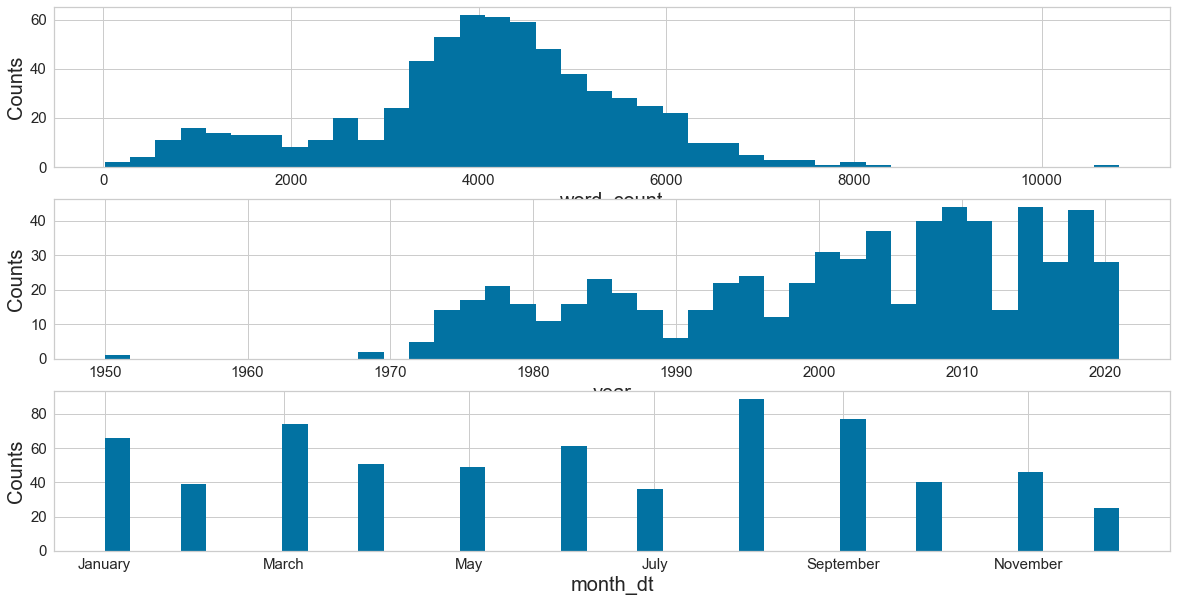

In [67]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 3, ncols = 1)

# Specify the features of interest
num_features = ['word_count', 'year', 'month_dt']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx == 2:
        date_form = DateFormatter('%B')
        ax.xaxis.set_major_formatter(date_form)
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)    
    else:
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)

plt.show()

Based on the plot above, we can make a few observations:  
- The overall number of talks increased as time has gone on.
- August seems to be a popular month for people to give talks at Brigham Young University (suggesting that it coincides with the beginning of the school year)

The next plot will give us count by topic.

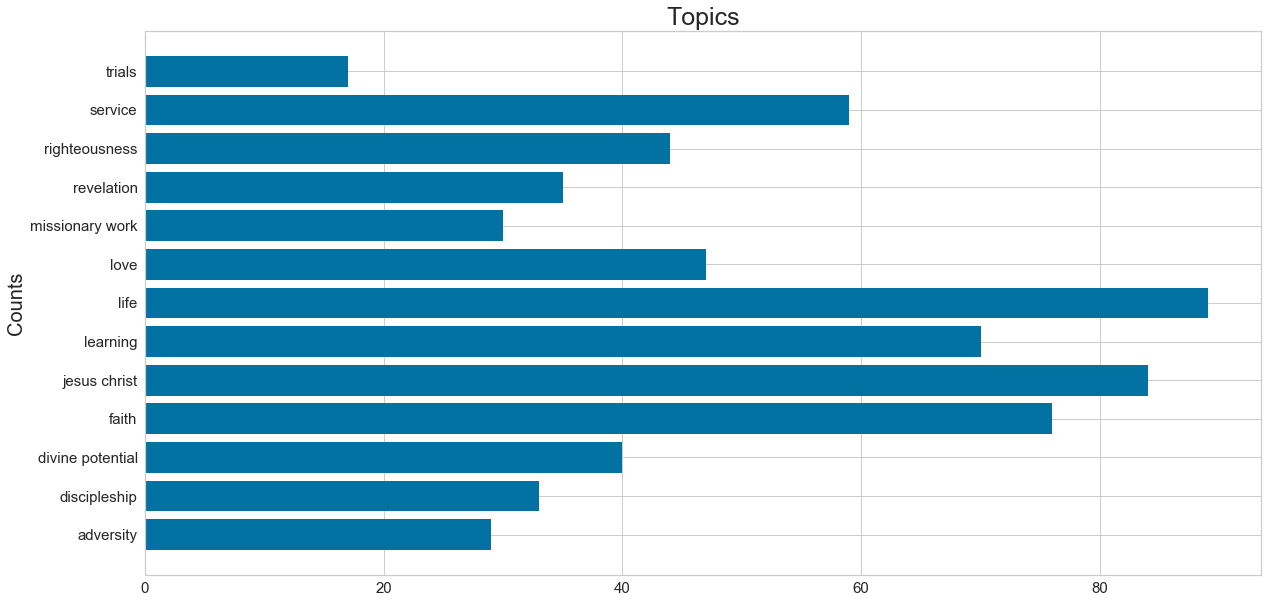

In [68]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
X_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['topic_singular']
Y_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes.barh(X_Topics, Y_Topics)
axes.set_title('Topics', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)

plt.show()


Observations from the topics bar chart:
- Jesus Christ and Life are the most popular topics (of the most popular topics).  
- All of the most popular seem to fall in line with a private religious university

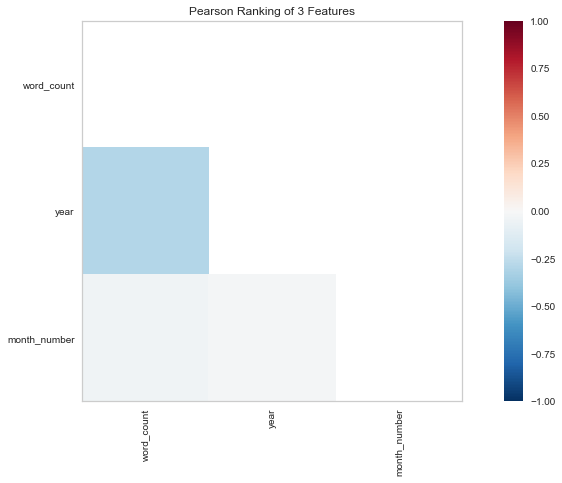

In [69]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['word_count', 'year', 'month_number']

# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

A few observations from the Pearson Ranking matrix plot:
- As the years increase (become more recent to our day), the speakers seem to have more to say (use more words).
- The later in the year, the less sermons are given.  Maybe this is due to July being a summer month with not a lot of the student body present on campus, and December has winter break.

The next plot will show a bar chart of the most popular topics (Faith, Jesus Christ, Learning, Life, and Service) and what month they were given.

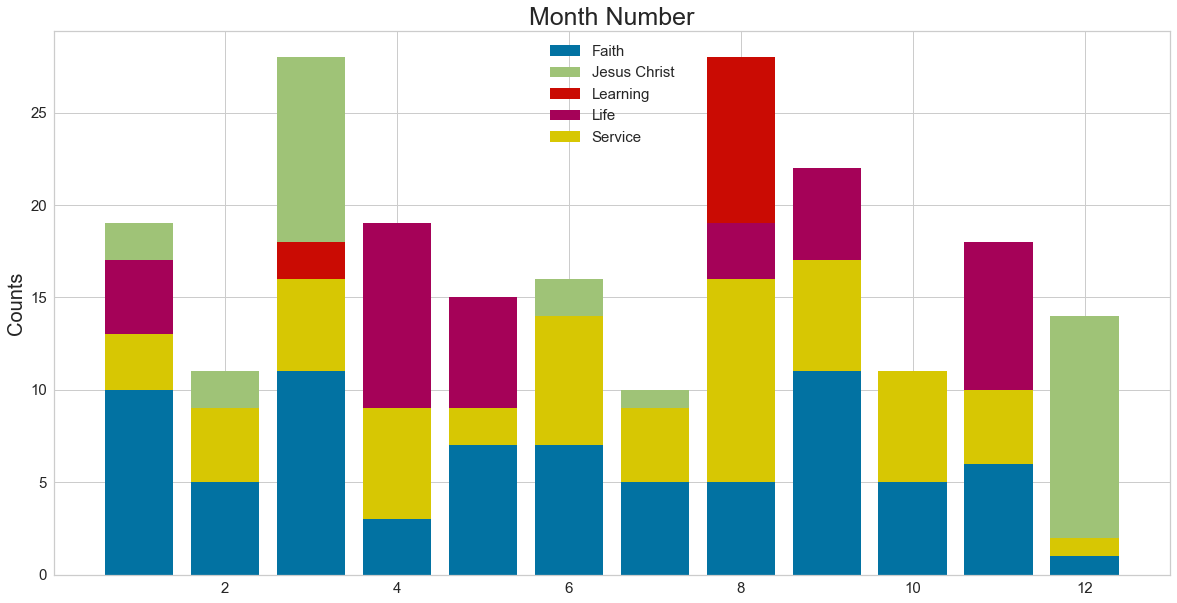

In [70]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visualizer
month_number_faith = df[df['topic_singular']=='faith']['month_number'].value_counts()

month_number_jc = df[df['topic_singular']=='jesus christ']['month_number'].value_counts()
month_number_jc = month_number_jc.reindex(index = month_number_faith.index)

month_number_learning = df[df['topic_singular']=='learning']['month_number'].value_counts()
month_number_learning = month_number_learning.reindex(index = month_number_faith.index)

month_number_life = df[df['topic_singular']=='life']['month_number'].value_counts()
month_number_life = month_number_life.reindex(index = month_number_faith.index)

month_number_service = df[df['topic_singular']=='service']['month_number'].value_counts()
month_number_service = month_number_service.reindex(index = month_number_faith.index)
# make the bar plot
p1 = axes.bar(month_number_faith.index, month_number_faith.values)
p2 = axes.bar(month_number_jc.index, month_number_jc.values, bottom=month_number_faith.values)
p3 = axes.bar(month_number_learning.index, month_number_learning.values, bottom=month_number_faith.values)
p4 = axes.bar(month_number_life.index, month_number_life.values, bottom=month_number_faith.values)
p5 = axes.bar(month_number_service.index, month_number_service.values, bottom=month_number_faith.values)
# date_form = DateFormatter('%B')
# axes.xaxis.set_major_formatter(date_form)
axes.set_title('Month Number', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)
axes.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Faith', 'Jesus Christ', 'Learning', 'Life', 'Service'), fontsize = 15)

plt.show()


The following observations can be made from the chart above:

- August is the most popular month for talks, with an overwhelming majority of the learning topics being contained there.
- December is a popular month to discuss Jesus Christ (more than likely due to Christmas).
- Faith and Service is a common theme no matter the time of year.
- Jesus Christ as a topic is popular in March (perhaps due to Easter?).

It will be interesting as we continue on with this project how these variables will play into the predictability of the project.

In Milestone 2, you should drop any features that are not useful for your model building. You should explain and justify why the feature dropped is not useful. You should address any missing data issues. Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary. Explain your process at each step. You can use any methods/tools you think are most appropriate. Again, keep in mind that this may look very different from what is done in the Titanic tutorial case study. You should do what makes sense for your project. Be careful to avoid data snooping in these steps.

Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary.

We will now create dummy variables for the categorical designations in the topic_singular column that will be later used for model analysis.  Instead of using a dictionary to assign values to the categories (i.e. adversity = 1, divine potential = 2, etc.), we will use the get_dummies section so that the model will not give more importance to a higher number.

In [71]:
# Assign the singular topics an number ID for model analysis

# df = pd.get_dummies(df, prefix='topic_singular', columns=['topic_singular'])
df.head(7)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 653
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   topic_singular    653 non-null    object        
 1   titles            653 non-null    object        
 2   speaker           653 non-null    object        
 3   speaker_position  653 non-null    object        
 4   date              653 non-null    object        
 5   talks             653 non-null    object        
 6   topics            653 non-null    object        
 7   word_count        653 non-null    int64         
 8   month             653 non-null    object        
 9   month_dt          653 non-null    datetime64[ns]
 10  year              653 non-null    int32         
 11  month_number      653 non-null    int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(8)
memory usage: 63.8+ KB


In Milestone 3, you will begin the process of model selection and evaluation. In addition, write step-by-step instructions for performing the model evaluation and selection part of your case study.

In Milestone 3, you should build and evaluate at least one model. You can use any methods/tools you think are most appropriate, but you should explain/justify why you are choosing the model(s) and evaluation metric(s) you choose. It is important to think about what type of model and metric makes sense for the context of your problem. If you are familiar with hyperparameter tuning, this would also be a great addition to your project.

Write a short overview/conclusion of the insights gained from your model building/evaluation.

There is a little more processing that we would like to take care before building our model. First we will lower case all
the words so words like 'Hello' and 'hello' can be treated the same.

In [72]:
# Lower case, remove stop words, and stem the talk text

df['talks_lowered'] = df['talks'].apply(lambda x: x.lower())
df['talks_lowered'][1]

'the greatest dichotomy, the greatest problem in the entire universe, consists of two facts. the first we can read in doctrine and covenants 1:31: “for i the lord cannot look upon sin with the least degree of allowance.” that means he can’t stand it, he can’t tolerate it, he can’t blink, or look the other way, or sweep it under the rug. he can’t tolerate sin in the least degree. the other side of the dichotomy is very simply put: i sin, and so do you. if that were all there were to the equation, the conclusion would be inescapable that we, as sinful beings, cannot be tolerated in the presence of god.but that is not all there is to the equation. this morning i would like to talk to you about the atonement of christ, that glorious plan by which this dichotomy can be resolved. i would like to share with you incidents from my own life that illustrate how the atonement works in a practical, everyday setting.believing christfirst is a story about my son, michael, who did something wrong when

Prior to model selection, we will tokenize our talks with sentences, words, and part-of-speech tagging.

In [73]:
# tokenization of the speeches into sentences.
from nltk.tokenize import sent_tokenize

df['sentence_tokenize'] = df['talks'].apply(lambda x: sent_tokenize(x))

In [74]:
# tokenization of the speeches into words
from nltk.tokenize import word_tokenize
df['word_tokenize'] = df['talks'].apply(lambda x: word_tokenize(x))

In [75]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
data = []

for i in range(df.shape[0]):
    text = df.iloc[i,14]
    talk_processed_list = []
    for word in text:
        if word not in set(stopwords.words('english')):
            talk_processed_list.append(stemmer.stem(word))
    proc_talk = " ".join(talk_processed_list)
    data.append(proc_talk)

print(data[1], len(data))

the greatest dichotomi , greatest problem entir univers , consist two fact . the first read doctrin coven 1:31 : “ for I lord look upon sin least degre allowance. ” that mean ’ stand , ’ toler , ’ blink , look way , sweep rug . He ’ toler sin least degre . the side dichotomi simpli put : I sin , . If equat , conclus would inescap , sin be , toler presenc god.but equat . thi morn I would like talk aton christ , gloriou plan dichotomi resolv . I would like share incid life illustr aton work practic , everyday setting.believ christfirst stori son , michael , someth wrong six seven year old . He ’ son , I ’ hard . I want better dad , even boy , I lean expect great deal . well , done someth I thought incred vile , I let know terribl . I sent room instruct , “ don ’ dare come I come get you. ” and I forgot . It hour later , I watch televis , I heard door open heard tent footstep come hall . I said , “ Oh , gosh , ” ran end hall see stand swollen eye tear cheek end . He look me—h ’ quit sure 

In [76]:
# pos 
import nltk
# nltk.download('averaged_perceptron_tagger')

df['word_pos'] = df['word_tokenize'].apply(lambda x: nltk.pos_tag(x))

We are now ready to build our model.  The model that we will build first is a Naive Bayes model.  The steps were adapted from a blog post on medium.com entitled "Text classification using the BagOfWords Approach with NLTK and Scikit Learn."
The actual code from the blog post can be found at https://github.com/CharlesRajendran/TextClassification/blob/master/classifier.py

The reason why this model was chosen is because the Naive Bayes model is a common model used when dealing with text
classification.  It was also used as the code is straightforward enough to follow and get a model created.

In [77]:
# adapted from CharlesRajendran TextClassification github

# creating the feature matrix
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
y = df.iloc[:, 0]
print(X.shape, y)

(653, 1000) 0                  life
1          jesus christ
2                 faith
3              learning
4            revelation
             ...       
649    divine potential
650           adversity
651        jesus christ
652        jesus christ
653            learning
Name: topic_singular, Length: 653, dtype: object


In [78]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=7)

The Naive Bayes model will now be used.

In [79]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

Our predictions will now be made.

In [80]:
# predict class

y_pred = classifier.predict(X_test)

We can now move onto the analytics portion of our Naive Bayes model.  We will look at the confusion matrix, the classification report (which includes precision, recall, f1-score), and the accuracy.

In [81]:
# Confusion matrix, classification report, accuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cm)
print()
print(cr)
print()
print(accuracy)

[[ 0  1  1  4  3  0  1  0  0  0  0  2  1]
 [ 1  0  1  0  2  0  3  0  0  0  1  0  0]
 [ 0  1  1  1  4  3  0  0  0  0  1  0  0]
 [ 0  0  1  8  3  0  2  1  0  3  2  0  0]
 [ 0  0  0  4 10  0  1  0  0  1  1  0  0]
 [ 0  0  2  2  0  8  1  0  0  1  4  0  0]
 [ 1  1  7  1  1  0  5  1  0  1  4  1  0]
 [ 0  0  0  0  5  0  1  4  0  0  1  2  0]
 [ 0  1  0  1  0  0  0  0  3  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  2  2  1  0]
 [ 0  1  1  0  1  0  0  1  0  0  1  0  0]
 [ 0  0  3  1  2  1  1  2  0  0  3  9  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  1  0]]

                  precision    recall  f1-score   support

       adversity       0.00      0.00      0.00        13
    discipleship       0.00      0.00      0.00         8
divine potential       0.06      0.09      0.07        11
           faith       0.33      0.40      0.36        20
    jesus christ       0.32      0.59      0.42        17
        learning       0.67      0.44      0.53        18
            life       0.33      0.22      0.

Based on this model, we have an accuracy of 38%.  As this is my first attempt at a model, anything better than 0% is a success for me. It is understood, however, that this can be greatly improved upon.  

We will now build a (Support Vector Machine) model.  The reason why this model is chosen is because of a Teams post by Ryan Long and Ori Rinamman that discusses "Factors to consider when choosing a predictive model."  On the post, there was a reference to the following website:

https://scikit-learn.org/dev/tutorial/machine_learning_map/index.html

On the scikit learn website, there is a flowchart that one can follow to help them determine the best model to use.  Based on the results of the flowchart, it lead to using a Support Vector Machine model.

In [82]:
from sklearn import svm
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cm)
print()
print(cr)
print()
print(accuracy)

[[ 1  1  0  3  0  0  4  1  0  0  1  1  1]
 [ 0  2  0  0  2  0  2  0  0  0  1  0  1]
 [ 0  1  1  3  2  0  3  1  0  0  0  0  0]
 [ 1  2  1 10  1  0  2  1  0  1  0  1  0]
 [ 0  1  0  2 12  0  0  0  1  0  0  1  0]
 [ 0  0  0  1  1 12  2  1  0  0  1  0  0]
 [ 0  3  2  0  1  2  9  1  0  0  5  0  0]
 [ 0  0  0  0  1  0  0 10  0  1  1  0  0]
 [ 0  0  0  0  2  0  0  0  2  0  2  0  0]
 [ 0  1  0  1  0  0  0  0  1  3  0  0  0]
 [ 0  2  0  0  1  0  0  0  0  0  2  0  0]
 [ 1  1  1  0  1  2  4  2  0  0  2  8  0]
 [ 0  0  0  1  0  0  1  0  0  0  0  0  0]]

                  precision    recall  f1-score   support

       adversity       0.33      0.08      0.12        13
    discipleship       0.14      0.25      0.18         8
divine potential       0.20      0.09      0.13        11
           faith       0.48      0.50      0.49        20
    jesus christ       0.50      0.71      0.59        17
        learning       0.75      0.67      0.71        18
            life       0.33      0.39      0.

The accuracy of the SVM model is 44% vs 38% for the Naive Bayes model.  For this reason, we will continue forward with the SVM model and will tune some of the parameters.  

Out of curiousity, lets use a different kernel and see what results we get.

In [83]:
from sklearn import svm
svm_classifier = svm.SVC(kernel='rbf', gamma=1, C=1)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cm)
print()
print(cr)
print()
print(accuracy)

[[ 0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0]]

                  precision    recall  f1-score   support

       adversity       0.00      0.00      0.00        13
    discipleship       0.00      0.00      0.00         8
divine potential       0.00      0.00      0.00        11
           faith       0.00      0.00      0.00        20
    jesus christ       0.10      1.00      0.19        17
        learning       0.00      0.00      0.00        18
            life       0.00      0.00      0.

C:\Users\Ramsey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ramsey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ramsey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Well, clearly these parameters were not as effective as the linear parameter and the Gaussian model.  In future weeks, more tuning will take place.

Overall conclusions: I am glad that a least a couple of models are in working order.  Since the SVM model (with the linear parameter) was the model that initially showed the best accuracy, we will continue to use this one.  

I am not certain if the topics will need to be decreased back to 5 or not, but I am curious to see what that result will yield.  I also am curious to know how to incorporate the other information gathered from the talks (speaker name, month, etc.) into the model to see if that can cause any differences.